In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

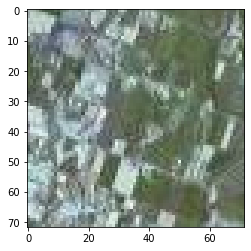

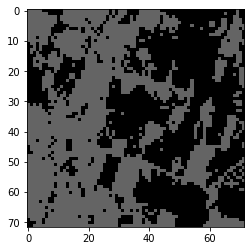

In [2]:
img = cv2.imread('/home/herry/project/side_project/machine_learning/cv/train/image/0.png')
plt.imshow(img)
plt.show()
mask = cv2.imread('/home/herry/project/side_project/machine_learning/cv/train/mask/0.png')
plt.imshow(mask*100)
plt.show()

In [3]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import os
from PIL import Image

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.transform = transform
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
    
    def __getitem__(self, index):
        image = Image.open(self.images_fps[index])
        mask = Image.open(self.masks_fps[index])
        if self.transform:
            image = transform(image)
            mask = transform(mask)
        
        return image, mask[0:1, :, :]
    
    def __len__(self):
        return len(self.ids)

In [5]:
train_images_dir = '/home/herry/project/side_project/machine_learning/cv/train/image/'
train_mask_dir = '/home/herry/project/side_project/machine_learning/cv/train/mask/'
test_images_dir = '/home/herry/project/side_project/machine_learning/cv/test/image/'
test_mask_dir = '/home/herry/project/side_project/machine_learning/cv/test/mask/'
transform = transforms.Compose([# transforms.Resize(255),
                                # transforms.CenterCrop(224), 
                                transforms.ToTensor()])

satellite_dataset = SatelliteDataset(train_images_dir, train_mask_dir, transform)
train_loader = DataLoader(satellite_dataset, batch_size=8, shuffle=True)
satellite_dataset = SatelliteDataset(test_images_dir, test_mask_dir, transform)
test_loader = DataLoader(satellite_dataset, batch_size=8, shuffle=False)

In [6]:
from torch import nn, optim
import torch
import torch.nn.functional as F

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.maxpool_conv(x)
            
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, 
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, 1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [8]:
net = Unet(3, 2)
optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(3):
    net.train()
    for i, (imgs, true_masks) in enumerate(train_loader):
        masks_pred = net(imgs)
        targe_tmp = true_masks.ceil()
        optimizer.zero_grad()
        loss = criterion(masks_pred, targe_tmp)
        print(f'epoch: {epoch+1}, {i+1}, {loss.item()}')

        loss.backward()
        optimizer.step()

epoch: 1, 1, 0.727729856967926


/home/herry/miniconda3/envs/py37/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


epoch: 1, 2, 0.816976010799408
epoch: 1, 3, 0.47505688667297363
epoch: 1, 4, 0.4054618179798126
epoch: 1, 5, 0.3664530813694
epoch: 1, 6, 0.31802093982696533
epoch: 1, 7, 0.31273937225341797
epoch: 1, 8, 0.2796437442302704
epoch: 1, 9, 0.22226931154727936
epoch: 1, 10, 0.2421780526638031
epoch: 1, 11, 0.2070568948984146
epoch: 1, 12, 0.23732014000415802
epoch: 1, 13, 0.28462931513786316
epoch: 1, 14, 0.21543648838996887
epoch: 1, 15, 0.268710196018219
epoch: 1, 16, 0.776531994342804
epoch: 1, 17, 0.26573053002357483
epoch: 1, 18, 0.2700812816619873
epoch: 1, 19, 0.3554498255252838
epoch: 1, 20, 0.42919814586639404
epoch: 2, 1, 0.3414325416088104
epoch: 2, 2, 0.4710933566093445
epoch: 2, 3, 0.26967206597328186
epoch: 2, 4, 0.2703835666179657
epoch: 2, 5, 0.24772915244102478
epoch: 2, 6, 0.3505898118019104
epoch: 2, 7, 0.24851863086223602
epoch: 2, 8, 0.3611823320388794
epoch: 2, 9, 0.2783605754375458
epoch: 2, 10, 0.22910986840724945
epoch: 2, 11, 0.22200718522071838
epoch: 2, 12, 0.209

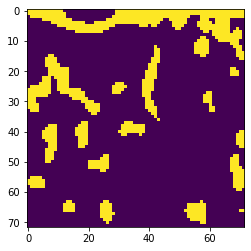

In [12]:
index = 1
pred_tmp = masks_pred.detach().numpy()[index][0]
pred_tmp = np.where(pred_tmp >= 0.5, 1, 0)
plt.imshow(pred_tmp)

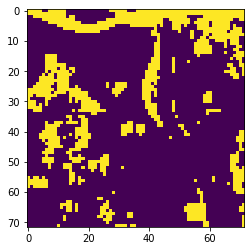

In [13]:
plt.imshow(targe_tmp.detach().numpy()[index][0])

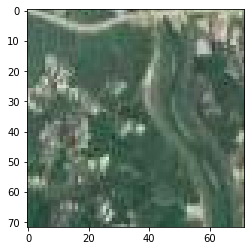

In [14]:
img = imgs[index].permute(1, 2, 0)
plt.imshow(img)

In [16]:
for i, (imgs, true_masks) in enumerate(test_loader):
    masks_pred = net(imgs)
    targe_tmp = true_masks.ceil()
    loss = criterion(masks_pred, targe_tmp)
    print(f'epoch: {epoch+1}, {i+1}, {loss.item()}')

epoch: 3, 1, 3.4957494735717773
epoch: 3, 2, 3.403513193130493
epoch: 3, 3, 3.416259765625
epoch: 3, 4, 3.4870288372039795
epoch: 3, 5, 3.4745047092437744
epoch: 3, 6, 3.4679884910583496
epoch: 3, 7, 3.388131618499756
epoch: 3, 8, 3.300962209701538
epoch: 3, 9, 3.434077024459839
epoch: 3, 10, 3.335623264312744
epoch: 3, 11, 3.3406665325164795
epoch: 3, 12, 3.5502312183380127
epoch: 3, 13, 3.163618564605713
epoch: 3, 14, 3.440897226333618
epoch: 3, 15, 3.5065464973449707
epoch: 3, 16, 3.430967330932617
epoch: 3, 17, 3.4528074264526367
epoch: 3, 18, 3.541949510574341
epoch: 3, 19, 3.4855334758758545
epoch: 3, 20, 3.468332290649414
epoch: 3, 21, 3.2193031311035156
epoch: 3, 22, 3.4376673698425293
epoch: 3, 23, 3.2171638011932373
epoch: 3, 24, 3.5821194648742676
epoch: 3, 25, 3.6319830417633057


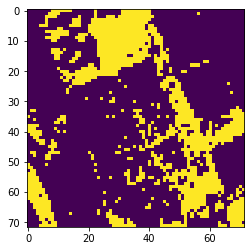

In [55]:
index = 5
plt.imshow(targe_tmp[index][0]*100)

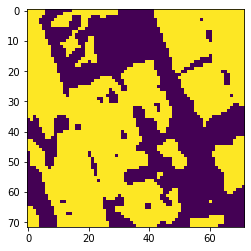

In [56]:
masks_pred = np.where(masks_pred >= 0.5, 1, 0)
plt.imshow(masks_pred[index][0]*100)

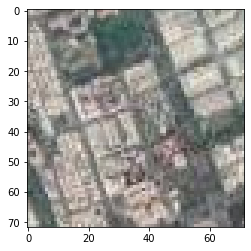

In [57]:
plt.imshow(imgs[index].permute(1, 2, 0))